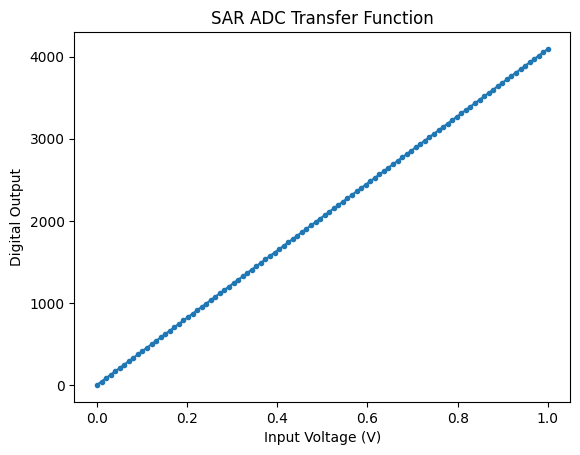

In [2]:
import numpy as np

# SAR ADC
def sar_adc(input_voltage, v_ref=1.0, bits=5, offset_bits=None):
    code = 0
    v_dac = 0
    step = 1.0 / 2
    for bit in range(bits):
        v_dac += step
        offset = offset_bits[bit] if offset_bits else 0
        if input_voltage < (v_dac + offset):
            v_dac -= step
        else:
            code |= (1 << (bits - 1 - bit))
        step /= 2
    return code

# Test SAR ADC
input_signal = np.linspace(0, 1, 100)
adc_output = [sar_adc(v, bits=12) for v in input_signal]
import matplotlib.pyplot as plt
plt.plot(input_signal, adc_output, '.-')
plt.xlabel("Input Voltage (V)")
plt.ylabel("Digital Output")
plt.title("SAR ADC Transfer Function")
plt.show()

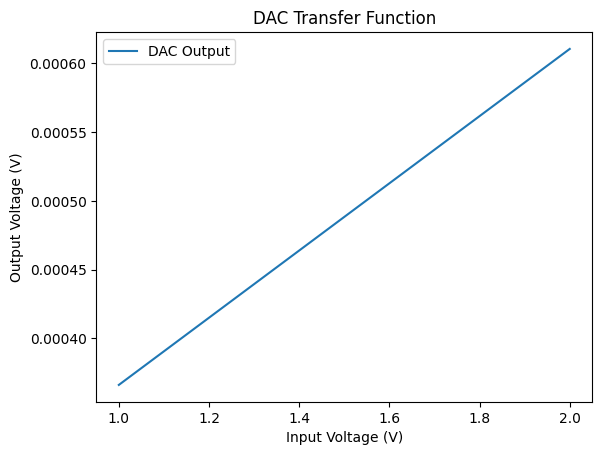

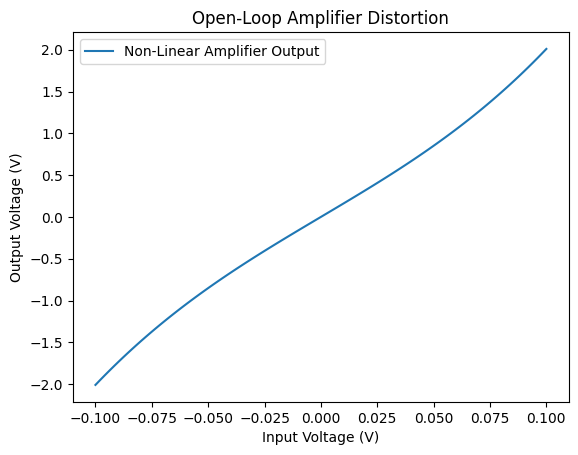

Digital Code: 614, Encoded Bits: [1, 0, 0, 1, 1, 0, 0, 1, 1, 0]


In [3]:
def dac(code, bits=6, v_ref=1.0):
    delta = v_ref / (2**bits)
    return code * delta + delta / 2

def non_linear_amplifier_A(input_voltage, gain=16, distortion_factor=0.1):
    return input_voltage * gain + distortion_factor * (input_voltage * gain)**3

def non_linear_amplifier_B(input_voltage, gain=16, distortion_factor=0.0):
    return input_voltage * gain  # Ideal path

# Test the DAC
input_signal = np.linspace(1, 2, 100)
dac_output = [dac(v, bits=12) for v in input_signal]

plt.plot(input_signal, dac_output, label="DAC Output")
plt.xlabel("Input Voltage (V)")
plt.ylabel("Output Voltage (V)")
plt.title("DAC Transfer Function")
plt.legend()
plt.show()

# Test the non-linear amplifier
input_signal = np.linspace(-0.1, 0.1, 100)
amp_output = [non_linear_amplifier_A(v) for v in input_signal]

plt.plot(input_signal, amp_output, label="Non-Linear Amplifier Output")
plt.xlabel("Input Voltage (V)")
plt.ylabel("Output Voltage (V)")
plt.title("Open-Loop Amplifier Distortion")
plt.legend()
plt.show()

def bitwise_encoding(code, bits):
    return [(code >> i) & 1 for i in range(bits)][::-1]  #MSB first

# Test encoding
code = sar_adc(0.6, bits=10)
encoded_bits = bitwise_encoding(code, bits=10)
print(f"Digital Code: {code}, Encoded Bits: {encoded_bits}")

In [4]:
from scipy.fft import fft

def compute_dnl_inl(adc_codes, n_bits):
    hist, _ = np.histogram(adc_codes, bins=2**n_bits, range=(0, 2**n_bits))
    ideal = np.mean(hist)
    dnl = (hist - ideal) / ideal
    inl = np.cumsum(dnl)
    return dnl, inl

def compute_sndr(signal, fs=1000):
    N = len(signal)
    signal = signal - np.mean(signal)
    spectrum = np.abs(fft(signal))[:N//2]
    fundamental_idx = np.argmax(spectrum[1:]) + 1
    fundamental_power = spectrum[fundamental_idx]**2
    total_power = np.sum(spectrum**2)
    noise_power = total_power - fundamental_power
    sndr = 10 * np.log10(fundamental_power / noise_power)
    return sndr

def power_spectral_density(signal, fs=1000):
    N = len(signal)
    noise = np.random.normal(0, 1, N)
    noise = noise - np.mean(noise)
    signal = signal + noise
    signal = signal - np.mean(signal)
    signal = signal / np.max(np.abs(signal))
    spectrum = np.abs(fft(signal))[:N//2]
    frequencies = np.fft.fftfreq(N, d=1/fs)[:N//2]
    return frequencies, spectrum**2

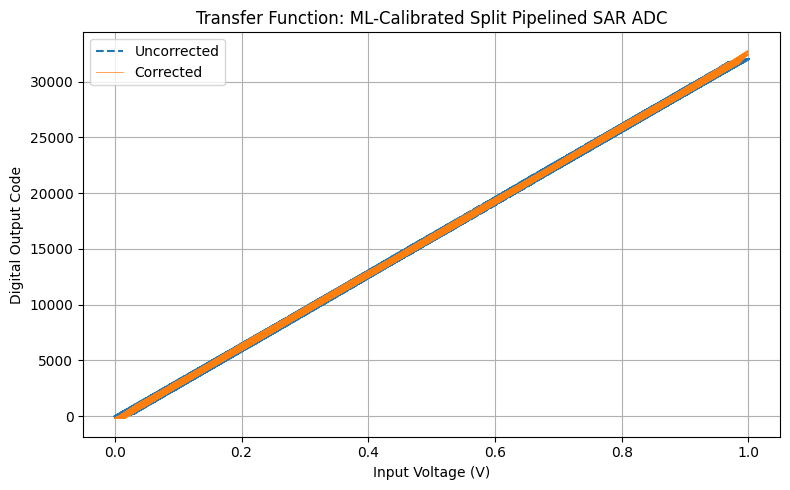

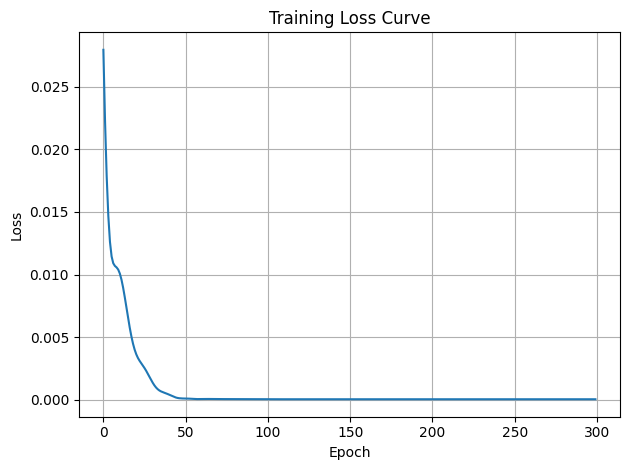

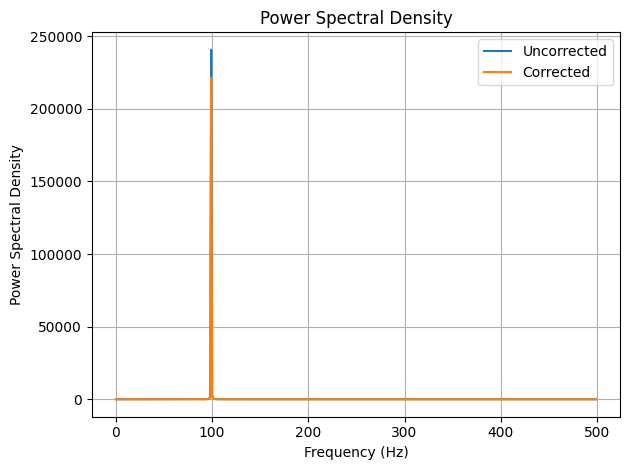

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class TrimPredictorNN(nn.Module):
    def __init__(self, bits=7):  # fine stage bits
        super().__init__()
        self.out = nn.Linear(bits, 1)  # simplified: linear model

    def forward(self, x):
        return self.out(x)

F = 1000
Fs = 10000
t = np.linspace(1, 100, 1000)
v_in = 0.5 + 0.49 * np.sin(2 * np.pi * F * t) + 0.02 * np.random.randn(1000)
v_in = np.clip(v_in, 0, 1)
bits_coarse = 5
bits_fine = 10
n_bits = bits_coarse + bits_fine
offset_bits = [ 0.015, -0.008, 0.002, -0.011, 0.0024 ]
offset_bits_ = [ -0.0085, 0.01, -0.0098, 0.0016, -0.0059 ]

X, y = [], []

for vin in v_in:
    # Channel A (includes non-linearities and offset bits)
    coarse_A = sar_adc(vin, bits=bits_coarse, offset_bits=offset_bits)
    dac_A = dac(coarse_A, bits=bits_coarse)
    residue_A = non_linear_amplifier_A(vin - dac_A)
    fine_A = sar_adc(residue_A, bits=bits_fine)
    XA_base = (coarse_A << bits_fine) + fine_A

    # Channel B (ML calibrated)
    coarse_B = sar_adc(vin, bits=bits_coarse, offset_bits=offset_bits_)
    dac_B = dac(coarse_B, bits=bits_coarse)
    residue_B = non_linear_amplifier_B(vin - dac_B)
    fine_B = sar_adc(residue_B, bits=bits_fine)
    XB_full = (coarse_B << bits_fine) + fine_B

    trim = (XB_full - XA_base) / (2**n_bits)  # normalize correction
    X.append(bitwise_encoding(fine_A, bits=bits_fine))
    y.append(trim)

#Train NN
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

model = TrimPredictorNN(bits=bits_fine)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.SmoothL1Loss()

loss_log = []
for epoch in range(300):
    optimizer.zero_grad()
    output = model(X_train)
    loss = loss_fn(output, y_train)
    loss.backward()
    optimizer.step()
    loss_log.append(loss.item())

corrected_output = []
uncorrected_output = []

for i, vin in enumerate(v_in):
    coarse = sar_adc(vin, bits=bits_coarse)
    dac_val = dac(coarse, bits=bits_coarse)
    residue = non_linear_amplifier_B(vin - dac_val)
    fine = sar_adc(residue, bits=bits_fine)
    XA_base = (coarse << bits_fine) + fine
    bits_input = torch.tensor(bitwise_encoding(fine, bits=bits_fine), dtype=torch.float32)
    trim = model(bits_input).item()
    XA_corrected = XA_base + int(trim * (2**n_bits))
    corrected_output.append(XA_corrected)
    uncorrected_output.append(XA_base)

plt.figure(figsize=(8, 5))
plt.plot(v_in, uncorrected_output, label="Uncorrected", linestyle='--')
plt.plot(v_in, corrected_output, label="Corrected", linewidth=0.5)
plt.xlabel("Input Voltage (V)")
plt.ylabel("Digital Output Code")
plt.title("Transfer Function: ML-Calibrated Split Pipelined SAR ADC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(loss_log)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(power_spectral_density(np.array(v_in) - np.array(uncorrected_output))[1])
plt.plot(power_spectral_density(np.array(v_in) - np.array(corrected_output))[1])
plt.title("Power Spectral Density")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.legend(["Uncorrected", "Corrected"])
plt.grid(True)
plt.tight_layout()
plt.show()

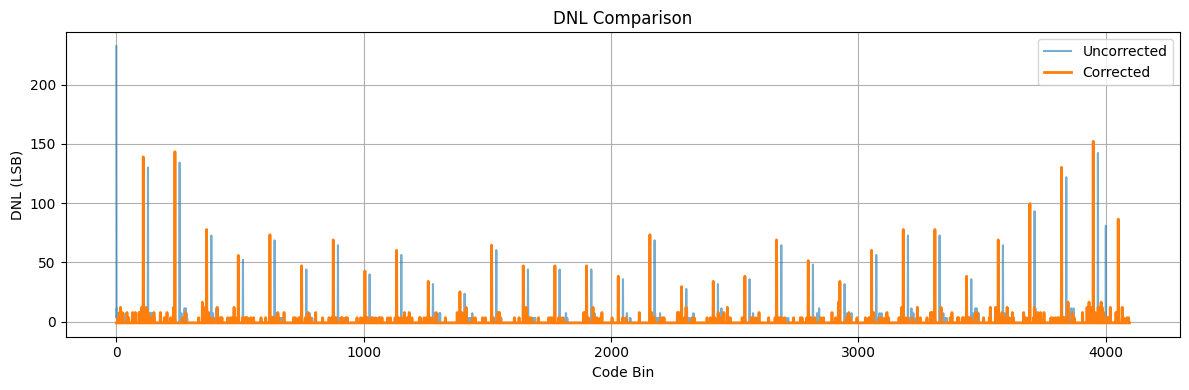

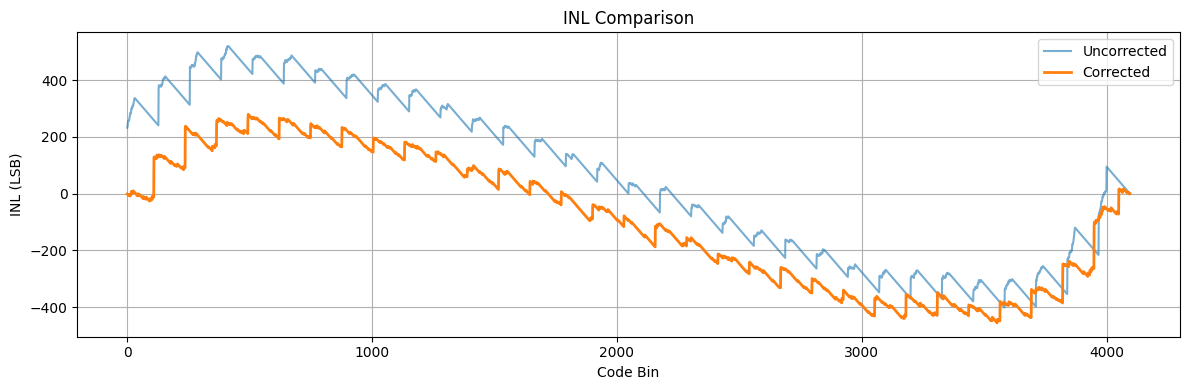

In [ ]:
n_bits = 12  # Or the total resolution you're using
dnl_uncorrected, inl_uncorrected = compute_dnl_inl(uncorrected_output, n_bits)
dnl_corrected, inl_corrected = compute_dnl_inl(corrected_output, n_bits)

# Plot DNL Comparison
plt.figure(figsize=(12, 4))
plt.plot(dnl_uncorrected, label="Uncorrected", alpha=0.6)
plt.plot(dnl_corrected, label="Corrected", linewidth=2)
plt.title("DNL Comparison")
plt.xlabel("Code Bin")
plt.ylabel("DNL (LSB)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot INL Comparison
plt.figure(figsize=(12, 4))
plt.plot(inl_uncorrected, label="Uncorrected", alpha=0.6)
plt.plot(inl_corrected, label="Corrected", linewidth=2)
plt.title("INL Comparison")
plt.xlabel("Code Bin")
plt.ylabel("INL (LSB)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [6]:
print(f"first 15 uncalibrated output codes: {uncorrected_output[:15]}")
print(f"first 15 ML-calibrated output codes: {corrected_output[:15]}")

first 15 uncalibrated output codes: [15478, 25644, 30720, 32000, 24576, 16387, 7168, 1118, 1024, 5265, 15360, 24576, 29813, 31894, 25752]
first 15 ML-calibrated output codes: [15728, 25714, 30536, 32439, 24392, 16206, 6984, 1279, 840, 5569, 15176, 24392, 29962, 32362, 26156]


Research Paper #2

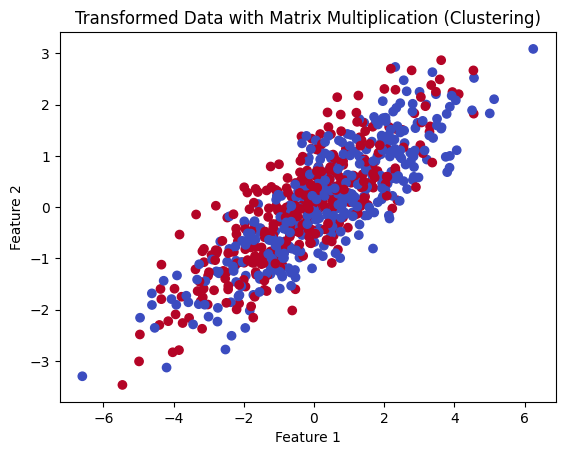

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.85      0.81       156
           1       0.82      0.75      0.78       144

    accuracy                           0.80       300
   macro avg       0.80      0.80      0.80       300
weighted avg       0.80      0.80      0.80       300

Accuracy: 80.00%


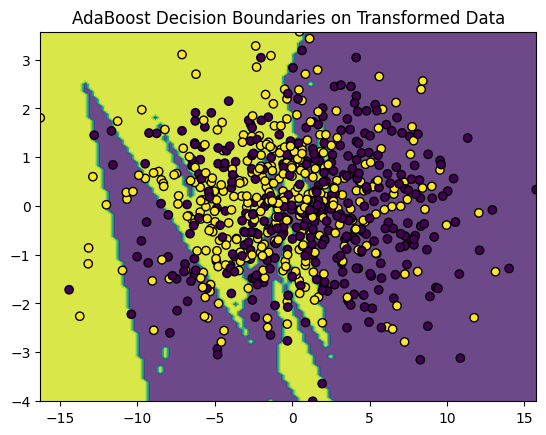

In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Simulating Matrix Multiplication for Feature Extraction and Classification
def matrix_multiply(input_data, matrix):
    # Ensure the shapes of input_data and matrix are compatible for multiplication
    if input_data.shape[1] != matrix.shape[0]:
        raise ValueError(f"Matrix multiplication error: input_data shape {input_data.shape} "
                         f"and matrix shape {matrix.shape} are incompatible.")
    return np.dot(input_data, matrix)

# Generate synthetic data with 2 clusters for clearer separation
np.random.seed(42)
n_samples = 1000
n_features = 10
n_clusters = 2

# Generate random data and cluster it into two groups
X = np.random.randn(n_samples, n_features)

# Use KMeans clustering to generate two distinct clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y = kmeans.fit_predict(X)  # Cluster labels as target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define a simple digital matrix for matrix multiplication
matrix = np.random.rand(n_features, n_features)  # e.g., a weight matrix for classification

# Perform matrix multiplication for feature extraction and classification
X_train_transformed = np.dot(X_train, matrix)
X_test_transformed = np.dot(X_test, matrix)

# Visualize the transformed data (optional, for understanding the matrix impact)
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=y_train, cmap='coolwarm')
plt.title("Transformed Data with Matrix Multiplication (Clustering)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Define the weak classifier (DecisionTreeClassifier with max_depth=1)
base_learner = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost (no `base_estimator`, use the weak learner directly)
ada_boost = AdaBoostClassifier(base_learner, n_estimators=50, random_state=42)

# Train the model
ada_boost.fit(X_train_transformed, y_train)

# Test the model
y_pred = ada_boost.predict(X_test_transformed)

# Evaluate the model performance
print("Classification Report:\n", classification_report(y_test, y_pred))

# Show the model's performance
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Now reduce dimensionality to 2D using PCA for visualization of decision boundaries
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_transformed)

# Plot decision boundaries using PCA reduced 2D data
xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min(), X_train_2d[:, 0].max(), 100),
                     np.linspace(X_train_2d[:, 1].min(), X_train_2d[:, 1].max(), 100))

Z = ada_boost.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', marker='o')
plt.title("AdaBoost Decision Boundaries on Transformed Data")
plt.show()